#Factors Influencing Airbnb Prices in London#

The goal of this project is to analyse which factors influence Airbnb listing prices in the city of London. This is a relevant business problem for hosts, property managers, investors, and policy makers who want to understand price drivers in the short-term rental market.

The analysis uses publicly available data from Inside Airbnb.
The research question guiding the project is:

Which factors drive Airbnb prices in London?

The dataset used comes from Inside Airbnb, an open-data project that provides publicly available information about Airbnb listings.
Data source: https://insideairbnb.com/get-the-data/

Downloaded files include:

- listings.csv.gz (main dataset with prices, host info, property details, reviews, neighbourhoods)
- calendar.csv.gz (optional, availability and price by day)
- neighbourhoods.csv (optional, neighbourhood names)

For this project, the analysis focuses mainly on listings.csv.gz, which contains all variables needed to answer the research question.

Note on Data Limitations
The dataset is scraped by Inside Airbnb and may contain missing values, incomplete host information, or inconsistent formatting.
Since it represents a snapshot in time, results do not capture seasonal patterns or price changes throughout the year.

#Loading the Dataset

In this step we load the London Airbnb dataset from Inside Airbnb.
The dataset contains 96,871 listings and 79 columns.
Each row represents one Airbnb listing in London.

In [17]:
import pandas as pd

df = pd.read_csv("listings.csv.gz")
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96871 entries, 0 to 96870
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            96871 non-null  int64  
 1   listing_url                                   96871 non-null  object 
 2   scrape_id                                     96871 non-null  int64  
 3   last_scraped                                  96871 non-null  object 
 4   source                                        96871 non-null  object 
 5   name                                          96871 non-null  object 
 6   description                                   94421 non-null  object 
 7   neighborhood_overview                         41208 non-null  object 
 8   picture_url                                   96865 non-null  object 
 9   host_id                                       96871 non-null 

#Cleaning the Price Column

The price column is stored as text (e.g., "$120.00").
To analyse prices, we remove the dollar sign and comma, and convert it to a numeric value.

In [18]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['price'].head()

0     70.0
1    149.0
2    411.0
3      NaN
4    210.0
Name: price, dtype: float64

#Checking Missing Values

Next, we check how many missing values each column has.
This helps us understand which columns need cleaning or can be removed from the analysis.

In [19]:
df.isnull().sum().sort_values(ascending=False)

neighbourhood_group_cleansed    96871
calendar_updated                96871
license                         96871
neighborhood_overview           55663
neighbourhood                   55662
                                ...  
maximum_nights_avg_ntm              0
availability_30                     0
availability_60                     0
availability_90                     0
amenities                           0
Length: 79, dtype: int64

#Removing Listings Without Price

Some listings do not have a price value.
Since our research question is about price, we remove rows where price is missing.

In [20]:
# Drop rows where price is missing
df = df.dropna(subset=['price'])

# Check how many rows we have now
df.shape

(61963, 79)

#Selecting Relevant Columns

The original dataset has 79 columns.
For this project, we focus on variables that may influence price:
- Location: neighbourhood_cleansed
- Property characteristics: room_type, property_type, accommodates, bedrooms, beds, bathrooms_text, minimum_nights
- Host characteristics: host_is_superhost, host_listings_count
- Demand/quality: number_of_reviews, review_scores_rating
- Target variable: price

We selected these columns because they represent four key factors that may influence price:

- Location (neighbourhood)
- Property characteristics (room type, bedrooms, bathrooms, accommodates)
- Host characteristics (superhost, host listings count)
- Demand & quality indicators (reviews, ratings)

In [21]:
cols = ['price','neighbourhood_cleansed', 'room_type','property_type','accommodates', 'bedrooms', 'beds',
    'bathrooms_text','minimum_nights','host_is_superhost','host_listings_count', 'number_of_reviews', 'review_scores_rating']
df_clean = df[cols].copy()
df_clean.head()


,price,neighbourhood_cleansed,room_type,property_type,accommodates,bedrooms,beds,bathrooms_text,minimum_nights,host_is_superhost,host_listings_count,number_of_reviews,review_scores_rating
0,70.0,Islington,Private room,Private room in rental unit,1,1.0,1.0,1 shared bath,1,t,2.0,55,4.85
1,149.0,Kensington and Chelsea,Entire home/apt,Entire rental unit,2,1.0,1.0,1 bath,4,f,1.0,97,4.80
2,411.0,Westminster,Entire home/apt,Entire rental unit,6,3.0,3.0,2 baths,3,t,3.0,56,4.77
4,210.0,Tower Hamlets,Entire home/apt,Entire condo,4,1.0,0.0,1 bath,5,f,3.0,15,4.53
5,280.0,Richmond upon Thames,Entire home/apt,Entire townhouse,5,3.0,3.0,1.5 baths,3,f,1.0,116,4.80


#Cleaning Key Variables

We apply simple transformations to make the data easier to analyse:
- host_is_superhost: convert "t"/"f" into 1/0
- bathrooms_text: extract the numeric part (e.g. "1.5 baths" → 1.5) into a new bathrooms column

In [22]:
# Convert host_is_superhost to numeric (1 for superhost, 0 for not)
df_clean['host_is_superhost'] = df_clean['host_is_superhost'].map({'t': 1, 'f': 0})

# Extract numeric value from bathrooms_text (e.g. "1.5 baths" -> 1.5)
df_clean['bathrooms'] = df_clean['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)

# Check result
df_clean[['host_is_superhost', 'bathrooms']].head()

,host_is_superhost,bathrooms
0,1.0,1.0
1,0.0,1.0
2,1.0,2.0
4,0.0,1.0
5,0.0,1.5


#Handling Missing Values in Selected Columns

We keep rows where the essential variables are present.
For simplicity, we drop rows with missing values in:
- bedrooms
- bathrooms
- review_scores_rating

We keep only listings that have enough information for analysis.

In [23]:
df_clean = df_clean.dropna(subset=['bedrooms', 'bathrooms', 'review_scores_rating'])

# Check how many rows remain
df_clean.shape

# Optional: check remaining missing values
df_clean.isnull().sum()

price                        0
neighbourhood_cleansed       0
room_type                    0
property_type                0
accommodates                 0
bedrooms                     0
beds                        55
bathrooms_text               0
minimum_nights               0
host_is_superhost         1173
host_listings_count         11
number_of_reviews            0
review_scores_rating         0
bathrooms                    0
dtype: int64

#Descriptive Statistics of Key Numerical Variables

We look at basic statistics (mean, median, min, max) of the main numerical variables.

In [24]:
df_clean[['price', 'accommodates', 'bedrooms', 'bathrooms',
          'minimum_nights', 'number_of_reviews', 'review_scores_rating']].describe()

,price,accommodates,bedrooms,bathrooms,minimum_nights,number_of_reviews,review_scores_rating
count,47503.000000,47503.000000,47503.000000,47503.000000,47503.000000,47503.000000,47503.000000
mean,193.705345,3.542766,1.532956,1.349894,4.338252,34.904385,4.670353
std,865.860821,2.166158,0.962697,0.652397,16.085888,64.283999,0.510761
min,10.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,77.000000,2.000000,1.000000,1.000000,1.000000,4.000000,4.570000
50%,132.000000,3.000000,1.000000,1.000000,2.000000,13.000000,4.820000
75%,211.000000,4.000000,2.000000,1.500000,3.000000,38.000000,5.000000
max,74100.000000,16.000000,15.000000,12.000000,999.000000,1902.000000,5.000000


#Cleaning Key Variables

To prepare the dataset for analysis, we standardize several important variables:

- host_is_superhost: Convert "t"/"f" values into numeric 1/0
- bathrooms: Extract the numeric value from the bathrooms_text column (e.g., "1.5 baths" → 1.5)
- bedrooms: Convert to numeric and handle missing values
- These transformations make it easier to group, aggregate, and visualize the data.

In [25]:
# Convert host_is_superhost from 't'/'f' to 1/0
df_clean['host_is_superhost'] = df_clean['host_is_superhost'].map({'t': 1, 'f': 0})

# Extract number from bathrooms_text (e.g. "1.5 baths" → 1.5)
df_clean['bathrooms'] = df_clean['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)

# Convert bedrooms to numeric (already numeric but ensure type)
df_clean['bedrooms'] = df_clean['bedrooms'].astype(float)

# Preview cleaned columns
df_clean[['host_is_superhost', 'bathrooms', 'bedrooms']].head()

,host_is_superhost,bathrooms,bedrooms
0,NaN,1.0,1.0
1,NaN,1.0,1.0
2,NaN,2.0,3.0
4,NaN,1.0,1.0
5,NaN,1.5,3.0


#Handling Missing Values in the Selected Columns

The cleaned dataset still has missing values for some important variables such as bedrooms, bathrooms, and ratings.
Since these variables are needed for analysis, we remove rows where they are missing.

This ensures a consistent, complete dataset for visualizations and conclusions.

In [26]:
# Drop rows missing key variables
df_clean = df_clean.dropna(subset=[
    'bedrooms',
    'bathrooms',
    'review_scores_rating'
])

# Check remaining missing values
df_clean.isnull().sum()

price                         0
neighbourhood_cleansed        0
room_type                     0
property_type                 0
accommodates                  0
bedrooms                      0
beds                         55
bathrooms_text                0
minimum_nights                0
host_is_superhost         47503
host_listings_count          11
number_of_reviews             0
review_scores_rating          0
bathrooms                     0
dtype: int64

#Creating New Features

To enrich the analysis and generate additional insights, we create two new variables:

- price_per_guest: price divided by number of guests the listing accommodates
- is_multi_host: indicates whether a host manages more than 2 listings (professional host)

These new features help explore pricing fairness and host behavior.

In [27]:
# Price per guest
df_clean['price_per_guest'] = df_clean['price'] / df_clean['accommodates']

# Multi-listing host indicator
df_clean['is_multi_host'] = df_clean['host_listings_count'] > 2

df_clean[['price_per_guest', 'is_multi_host']].head()

,price_per_guest,is_multi_host
0,70.0,False
1,74.5,False
2,68.5,True
4,52.5,True
5,56.0,False


#Average Price by Room Type

This plot shows how the average price varies across different room types in London.
This helps identify whether entire homes, private rooms, or shared rooms are priced differently.

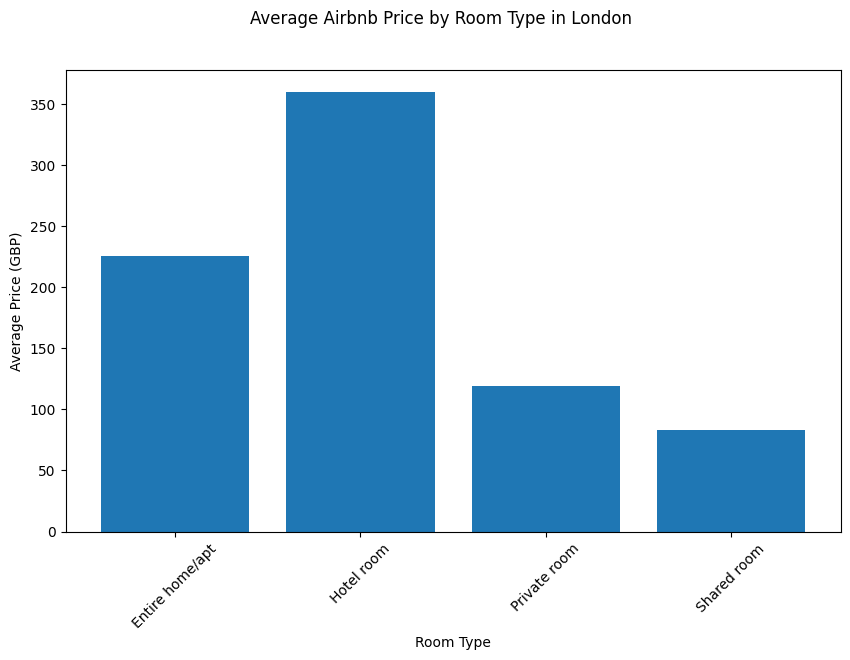

In [28]:
import matplotlib.pyplot as plt

avg_price_by_room = df_clean.groupby('room_type')['price'].mean()

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(avg_price_by_room.index, avg_price_by_room.values)

ax.set_ylabel("Average Price (GBP)")
ax.set_xlabel("Room Type")
fig.suptitle("Average Airbnb Price by Room Type in London")

plt.xticks(rotation=45)
plt.show()

Hotel rooms are the most expensive category, suggesting that professional operators price their units at a premium. Entire homes are also significantly more expensive than private or shared rooms due to greater privacy and space.

#Average Price by Neighbourhood (Top 10)

We compute the 10 neighbourhoods with the highest average prices to understand how location influences pricing.

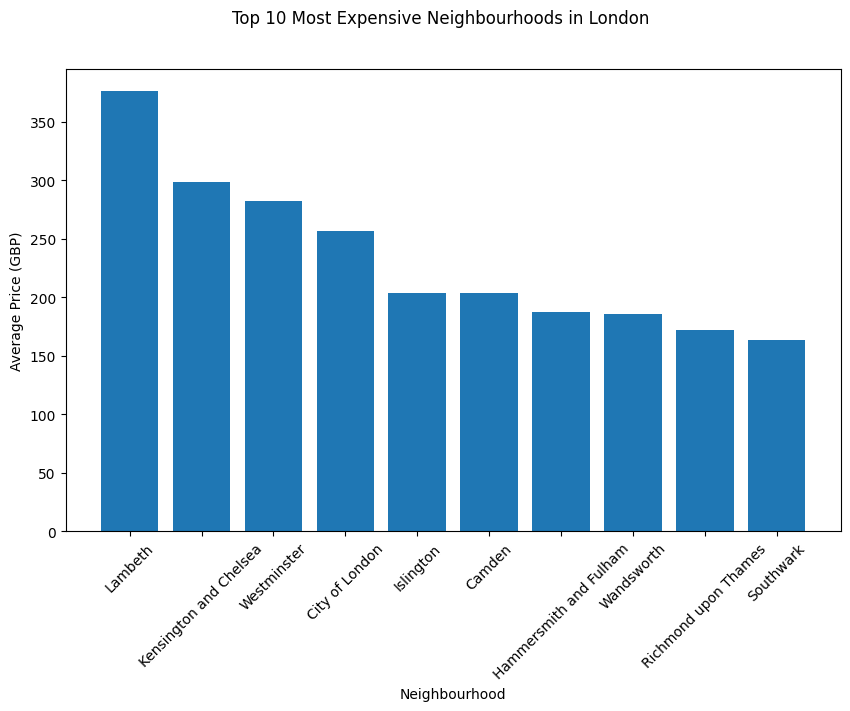

In [29]:
top10_neigh = (
    df_clean.groupby('neighbourhood_cleansed')['price']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(top10_neigh.index, top10_neigh.values)

ax.set_ylabel("Average Price (GBP)")
ax.set_xlabel("Neighbourhood")
fig.suptitle("Top 10 Most Expensive Neighbourhoods in London")

plt.xticks(rotation=45)
plt.show()

Central boroughs such as Lambeth, Kensington & Chelsea, and Westminster have the highest prices, reflecting high demand and proximity to major attractions. Prices decrease farther from the city center.

#Relationship Between Number of Guests and Price

This scatter plot shows how price increases with the number of guests a listing can accommodate.

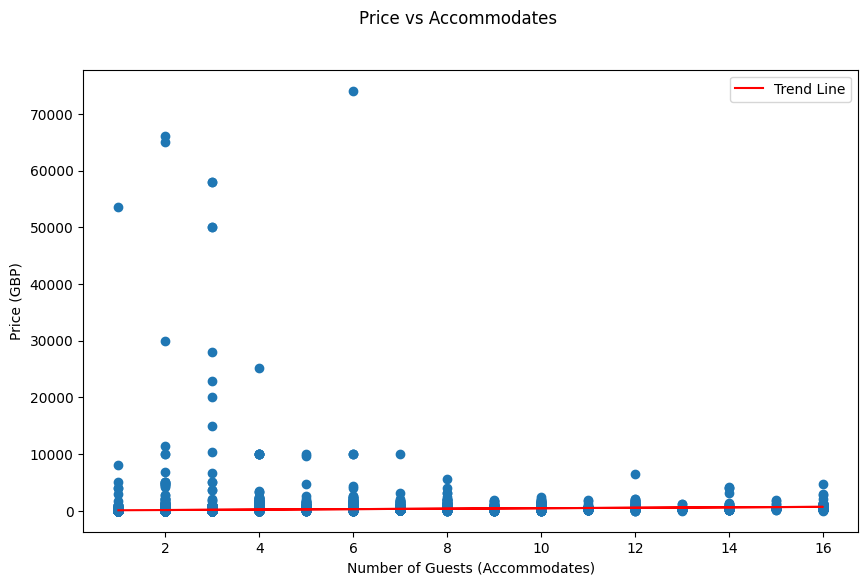

In [30]:
import numpy as np

x = df_clean['accommodates']
y = df_clean['price']

# compute slope (m) and intercept (b)
m, b = np.polyfit(x, y, 1)
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(x, y)
ax.set_xlabel("Number of Guests (Accommodates)")
ax.set_ylabel("Price (GBP)")
fig.suptitle("Price vs Accommodates")

# Trend line
ax.plot(x, m*x + b, color='red', label='Trend Line')
ax.legend()

plt.show()

Larger listings tend to have higher prices, but the relationship is weak because price is influenced by many factors (location, room type, amenities). The outliers represent luxury properties.

#Cleaning host_is_superhost for Plot 4

Before plotting, we make sure the host_is_superhost column is fully numeric and contains no missing values. This prevents plotting errors.

In [31]:
# Recreate host_is_superhost from the original df and clean it

# Go back to the original text column
df_clean['host_is_superhost'] = df['host_is_superhost']

# Map 't' / 'f' to 1 / 0
df_clean['host_is_superhost'] = df_clean['host_is_superhost'].map({'t': 1, 'f': 0})

# Fill missing with 0 (assume non-superhost) and convert to int
df_clean['host_is_superhost'] = df_clean['host_is_superhost'].fillna(0).astype(int)

# Check values
df_clean['host_is_superhost'].value_counts(dropna=False)

host_is_superhost
0    34200
1    13303
Name: count, dtype: int64

#Superhost vs Non-Superhost Pricing

This compares average prices charged by superhosts versus non-superhosts.



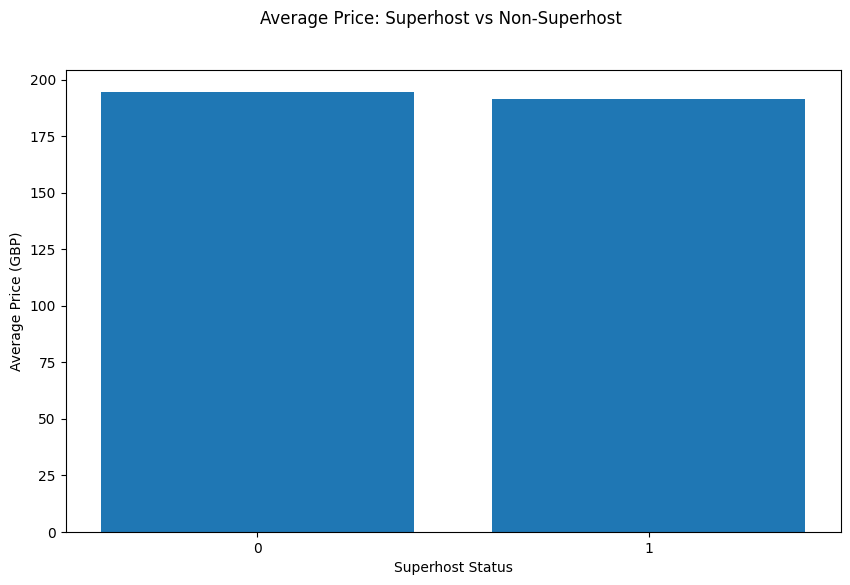

In [32]:
avg_price_super = df_clean.groupby('host_is_superhost')['price'].mean()

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(avg_price_super.index.astype(str), avg_price_super.values)

ax.set_ylabel("Average Price (GBP)")
ax.set_xlabel("Superhost Status")
fig.suptitle("Average Price: Superhost vs Non-Superhost")

plt.show()


Superhosts do not charge significantly higher prices than non-superhosts. This suggests that location and property type influence pricing more than host status.

#Conclusions

From this project, we can see that Airbnb prices in London are mostly influenced by where the property is located and what type of room it offers. Entire homes and hotel rooms are much more expensive, while private and shared rooms stay on the cheaper side. Neighbourhoods in central London, like Westminster or Kensington & Chelsea, clearly cost more because they’re closer to major landmarks and popular areas. Listings that fit more guests usually cost more too, although the relationship isn’t very strong because there are lots of outliers and very different types of properties. One interesting finding is that superhosts don’t really charge more than normal hosts, so being a superhost doesn’t seem to affect the price much. Overall, the strongest factors shaping Airbnb prices are location and room type, not host status.

#Limitations

Even though the analysis gives some useful results, it has a few limitations. First, the data represents only one moment in time, so we don’t see how prices change throughout the year or during holidays. Some columns have a lot of missing values, which means we had to drop many rows and might have lost useful information. There are also some extreme outliers — super expensive luxury homes — which can make average prices look higher than they really are. Also, this project only uses the main listings dataset and doesn’t include the calendar file, so we can’t study things like real occupancy or how often places get booked. Finally, this analysis is based on correlations, so it can show patterns but cannot prove the exact reasons why prices behave the way they do.

#Improvements

To make this project better in the future, several things could be added. Using the calendar dataset would help us understand seasonality, demand, and real revenue, giving a much clearer picture of how listings actually perform. We could also combine multiple datasets using SQL to get more detailed information about neighbourhoods or booking patterns. Another improvement would be trying a simple machine learning model, like linear regression, to predict prices based on different features. We could also clean the data more by removing outliers or analyzing them separately. Finally, comparing London to another city would make the results more interesting and show whether these pricing patterns are unique to London or common in other places too

#Use of AI

Parts of the structure and some explanations of this notebook were assisted by an AI tutor. All code was written, executed, and understood by us, and we are responsible for the analysis and conclusions.